# Graduation Project: Exploratory Data Analysis (EDA) for Arabic Hate Speech Detection

This notebook performs EDA on a dataset of Arabic sports tweets labeled as "hate" or "not hate". It covers preprocessing, frequency analysis, N-grams, TF-IDF, and various visualizations tailored for Arabic text.

### 1. Environment Setup
Installing specific libraries required for handling Arabic text rendering (reshaping/bidi) and NLP tools (Camel Tools).

In [ ]:
# Install libraries for correct Arabic text display in plots
!pip install arabic-reshaper python-bidi

# Install CAMEL Tools for Arabic NLP preprocessing
!pip install camel-tools

### 2. Importing Libraries and Loading Data
Here we import necessary analysis libraries and load the dataset. We also derive basic features like word counts and character lengths.

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from camel_tools.tokenizers.word import simple_word_tokenize
from camel_tools.tagger import common
from camel_tools.disambig.mle import MLEDisambiguator

# Libraries for fixing Arabic text display in plots (Right-to-Left support)
from bidi.algorithm import get_display
from arabic_reshaper import reshape

from collections import Counter
import matplotlib.pyplot as plt
from nltk import ngrams
import pandas as pd
import numpy as np
import re

# Load the dataset
df = pd.read_csv('sports_tweets.csv')
df = df.drop(columns=['lemmatized_tweet'])
# Split tweets into individual words (tokenization)
df['words'] = df['tweet'].str.split()

# Calculate the number of words per tweet
df['word_count'] = df['tweet'].apply(lambda x: len(x.split()))

# Calculate the character length of each tweet
df['length'] = df['tweet'].apply(lambda x: len(x))

# Display the first 10 rows to verify data loading
df.head(10)

,tweet,label,words,word_count,length
0,تخيل تخيل اعتمد علي غريزمان وموراتا ولله منتهي...,hate,"[تخيل, تخيل, اعتمد, علي, غريزمان, وموراتا, ولل...",40,228
1,بطولات عهد فهد بن نافل خلال سنوات فقط حتي الان...,not,"[بطولات, عهد, فهد, بن, نافل, خلال, سنوات, فقط,...",33,182
2,اللي يلعبون زي خدمي يستاهلوا التشكيل الاساسي ا...,hate,"[اللي, يلعبون, زي, خدمي, يستاهلوا, التشكيل, ال...",11,70
3,اداء فاشل طاقيه اليوم حسونا بالاحباط المباراة ...,hate,"[اداء, فاشل, طاقيه, اليوم, حسونا, بالاحباط, ال...",10,65
4,اداء فاشل خدمي اليوم حسونا بالاحباط المباراة ا...,hate,"[اداء, فاشل, خدمي, اليوم, حسونا, بالاحباط, الم...",10,64
5,فريق الفتح مسخرة يستاهل,hate,"[فريق, الفتح, مسخرة, يستاهل]",4,23
6,امل النصر الوحيد اسيا فوز الهلال علي الاتحاد ك...,not,"[امل, النصر, الوحيد, اسيا, فوز, الهلال, علي, ا...",37,208
7,الجمهور مقرف عندك فايدة,hate,"[الجمهور, مقرف, عندك, فايدة]",4,23
8,مسلي آل معمر لقا تلفزيوني يقول المدرب يمثل فقط...,not,"[مسلي, آل, معمر, لقا, تلفزيوني, يقول, المدرب, ...",41,224
9,ذكيا الاحترام والتقدير لجهود اداره يكونون خدعه...,not,"[ذكيا, الاحترام, والتقدير, لجهود, اداره, يكونو...",32,191


### 3. Class Segmentation & Frequency Analysis
We split the dataframe into Hate and Non-Hate classes to analyze the most frequent words in each category separately.

In [18]:
# Create separate dataframes for each class
not_hate_tweets = df[df['label'] == 'not']
hate_tweets = df[df['label'] == 'hate']

In [19]:
# Function to get the N most common words in a corpus
def get_top_n_words(corpus, n=None):
    words = []
    for text in corpus:
        for word in text.split():
            words.append(word)

    word_counts = Counter(words)
    return word_counts.most_common(n)

# Function to calculate total word count in a dataframe subset
def num_of_words(df):
    return df['word_count'].sum()


# Get the top 10 words for Non-Hate tweets
not_hate_tweets_top_words = get_top_n_words(not_hate_tweets['tweet'], n=10)
not_hate_tweets_word_count = num_of_words(not_hate_tweets)
print("Top", 10, " non-hate tweets' words:")
print(not_hate_tweets_top_words)

# Get the top 10 words for Hate tweets
hate_tweets_top_words = get_top_n_words(hate_tweets['tweet'], n=10)
hate_tweets_word_count = num_of_words(hate_tweets)
print("\nTop", 10, "words in hate tweets:")
print(hate_tweets_top_words)

Top 10  non-hate tweets' words:
[('مسلي', 537), ('النصر', 492), ('معمر', 478), ('ال', 386), ('نادي', 367), ('علي', 242), ('رايس', 229), ('الهلال', 209), ('النادي', 181), ('آل', 163)]

Top 10 words in hate tweets:
[('المباراة', 286), ('انتهت', 278), ('بنتيجة', 278), ('الهلال', 186), ('اللي', 138), ('طاقيه', 129), ('اطقطق', 124), ('النصر', 114), ('انت', 113), ('ان', 111)]


### 4. Feature Extraction: TF-IDF
Converting the text corpus into numerical feature vectors using Term Frequency-Inverse Document Frequency (TF-IDF) to identify weighted word importance.

In [20]:
# Combine all tweets into a single string corpus
corpus = ' '.join(df['tweet'])

# Create a TfidfVectorizer object
vectorizer = TfidfVectorizer()

# Fit and transform the corpus to generate the TF-IDF matrix
tfidf_matrix = vectorizer.fit_transform(corpus.split())

# Extract feature names (vocabulary)
feature_names = vectorizer.get_feature_names_out()

# Create a DataFrame for better visualization of TF-IDF scores
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

# Display the first few rows of the TF-IDF dataframe
print(tfidf_df.head())

   آتي  آحجز  آخر  آخرها  آستلم  آسيا  آفات   آل  آول  االلاعبين  ...  يوميا  \
0  0.0   0.0  0.0    0.0    0.0   0.0   0.0  0.0  0.0        0.0  ...    0.0   
1  0.0   0.0  0.0    0.0    0.0   0.0   0.0  0.0  0.0        0.0  ...    0.0   
2  0.0   0.0  0.0    0.0    0.0   0.0   0.0  0.0  0.0        0.0  ...    0.0   
3  0.0   0.0  0.0    0.0    0.0   0.0   0.0  0.0  0.0        0.0  ...    0.0   
4  0.0   0.0  0.0    0.0    0.0   0.0   0.0  0.0  0.0        0.0  ...    0.0   

   يوميات  يومين  يونايتد  يونايد  يونغ  يوهمهم  يوهه  يوو  گولت  
0     0.0    0.0      0.0     0.0   0.0     0.0   0.0  0.0   0.0  
1     0.0    0.0      0.0     0.0   0.0     0.0   0.0  0.0   0.0  
2     0.0    0.0      0.0     0.0   0.0     0.0   0.0  0.0   0.0  
3     0.0    0.0      0.0     0.0   0.0     0.0   0.0  0.0   0.0  
4     0.0    0.0      0.0     0.0   0.0     0.0   0.0  0.0   0.0  

[5 rows x 12715 columns]


### 5. Visualizing N-Grams (Bigrams & Trigrams)
Analyzing sequences of words (2 words and 3 words) to understand context and common phrases used in both classes.

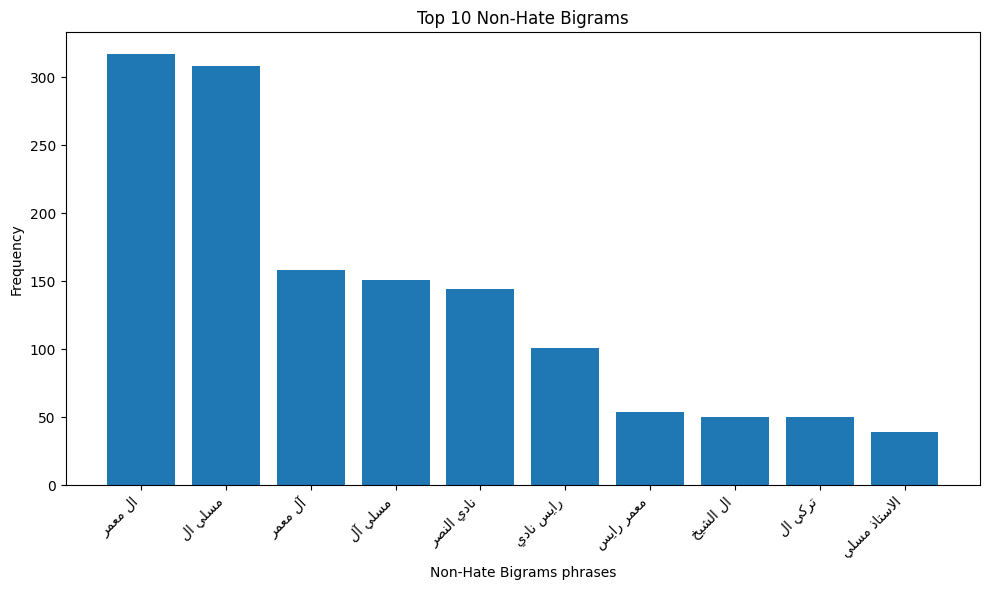

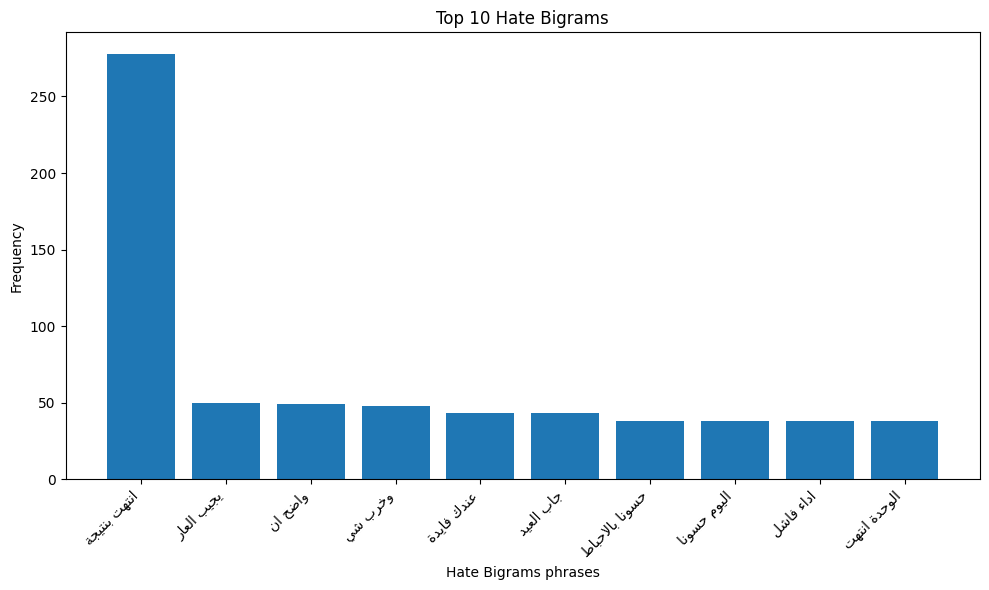

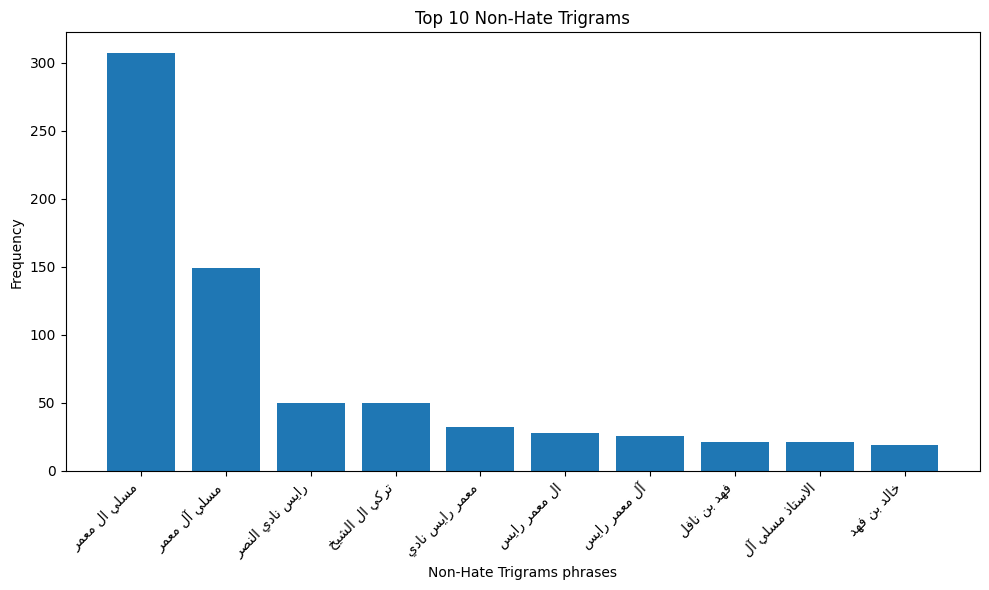

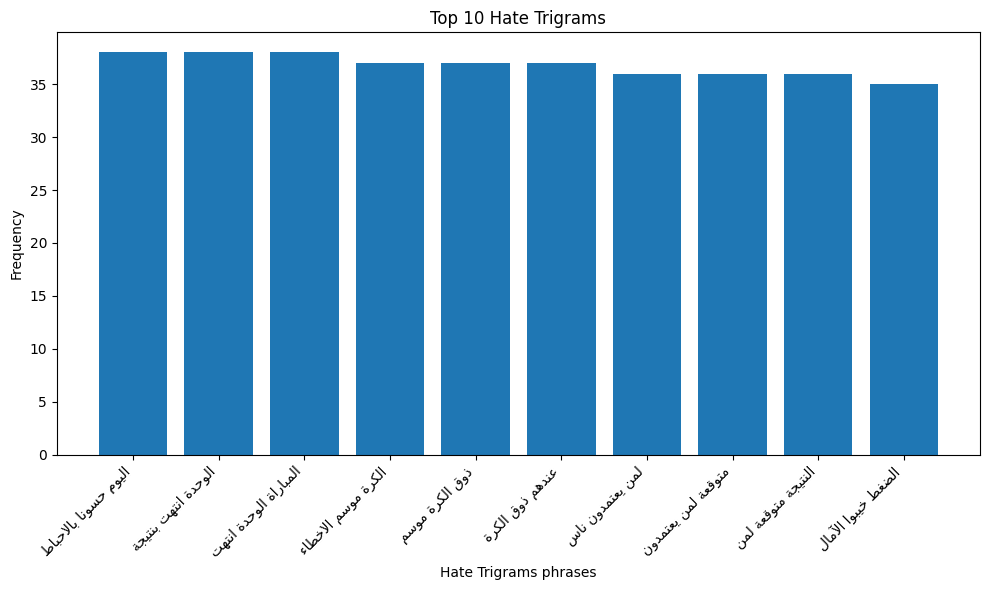

In [21]:
# Function to generate N-grams from text
def generate_ngrams(text, n):
  tokens = text.split()
  return list(ngrams(tokens, n))

# Function to calculate top N N-grams frequency
def get_top_n_ngrams(corpus, n=None):
  ngrams_list = []
  for text in corpus:
    ngrams_list.extend(generate_ngrams(text, n))

  ngram_counts = Counter(ngrams_list)
  return ngram_counts.most_common(10)

# Generate Bigrams (2 words) and Trigrams (3 words)
# Note: get_display(reshape(t)) is used to correctly format Arabic text for visual output
not_hate_tweets_top_bigrams = get_top_n_ngrams ([get_display(reshape(t)) for t in not_hate_tweets['tweet']], n=2)
not_hate_tweets_top_trigrams = get_top_n_ngrams([get_display(reshape(t)) for t in not_hate_tweets['tweet']], n=3)
hate_tweets_top_bigrams = get_top_n_ngrams     ([get_display(reshape(t)) for t in hate_tweets['tweet']], n=2)
hate_tweets_top_trigrams = get_top_n_ngrams    ([get_display(reshape(t)) for t in hate_tweets['tweet']], n=3)

# Plotting function for N-Grams
def barchart_n_grams(title, ngram_data):
  ngrams_labels, counts = zip(*ngram_data)
  # Create the bar chart
  plt.figure(figsize=(10, 6))
  plt.bar(range(len(ngrams_labels)), counts)
  # Join tuples to string for x-axis labels
  plt.xticks(range(len(ngrams_labels)), [' '.join(n) for n in ngrams_labels], rotation=45, ha='right')
  plt.xlabel(f"{title} phrases")
  plt.ylabel('Frequency')
  plt.title(f'Top 10 {title}')
  plt.tight_layout()
  plt.show()

# Generate charts
barchart_n_grams("Non-Hate Bigrams", not_hate_tweets_top_bigrams)
barchart_n_grams("Hate Bigrams", hate_tweets_top_bigrams)
barchart_n_grams("Non-Hate Trigrams", not_hate_tweets_top_trigrams)
barchart_n_grams("Hate Trigrams", hate_tweets_top_trigrams)

### 6. Log-Odds Analysis: Most Discriminative Words
This section uses log-odds ratios to identify words that are strongly distinctive to one class (Hate) versus the other (Non-Hate), providing deeper insight than simple frequency counts.

Top Hate Indicative Words:
المباراة 5.74
انتهت 5.71
بنتيجة 5.71
اطقطق 4.91
طحلبي 4.34
اللي 4.32
الآمال 4.22
والله 4.22
الوحدة 4.22
العار 4.07
حمار 4.05
وخرب 3.97
للآخر 3.95
فايدة 3.87
طاقيه 3.85
اللاعبين 3.84
الله 3.8
بالاحباط 3.77
الرياضة 3.77
ذوق 3.75

Top Non-Hate Indicative Words:
مسلي -6.21
معمر -6.09
اداره -4.42
ارحليامسلي -4.33
آل -4.33
رايس -4.26
البكيري -3.81
الهلالالنصر -3.79
فهد -3.77
شكرا -3.58
الرايس -3.5
نافل -3.35
قضيه -3.35
الاستاذ -3.27
جارسيا -3.05
يحق -3.05
واله -3.03
الرياضي -2.91
اله -2.86
اجانب -2.81


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65010 (\N{ARABIC LIGATURE ALLAH ISOLATED FORM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


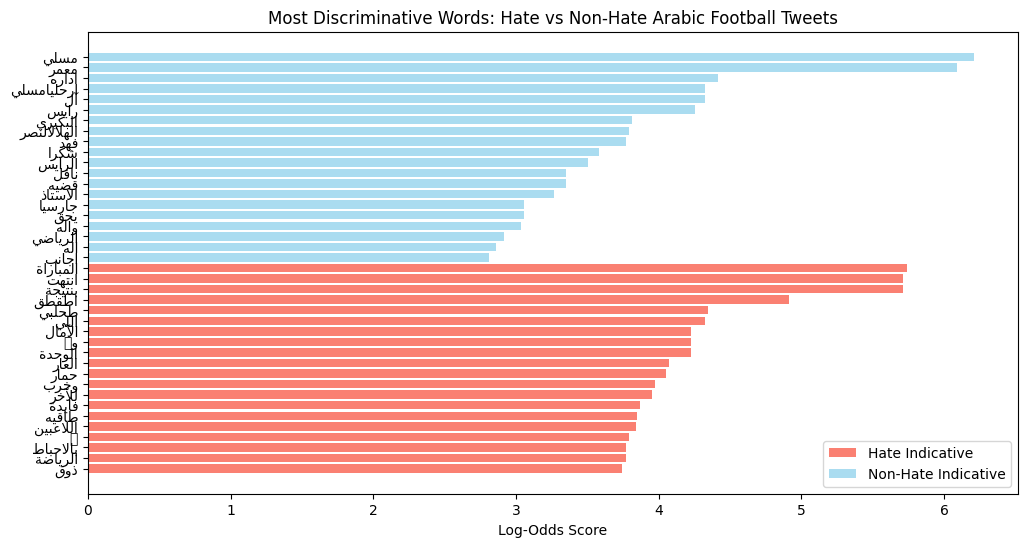

In [22]:
# Separate tokens by class for Log-Odds calculation
non_hate_tokens = [token for tokens in not_hate_tweets['words'] for token in tokens]
hate_tokens = [token for tokens in hate_tweets['words'] for token in tokens]

# Count frequencies
non_hate_counts = Counter(non_hate_tokens)
hate_counts = Counter(hate_tokens)

# Total number of words per class
total_non_hate = sum(non_hate_counts.values())
total_hate = sum(hate_counts.values())

# Create vocabulary set from all words
all_words = set(non_hate_counts.keys()) | set(hate_counts.keys())

log_odds = {}

# Calculate Log-Odds for each word
for word in all_words:
    # Add-one smoothing to avoid division by zero
    freq_hate = hate_counts.get(word, 0) + 1
    freq_non = non_hate_counts.get(word, 0) + 1

    # Probability per class
    p_hate = freq_hate / (total_hate + len(all_words))
    p_non = freq_non / (total_non_hate + len(all_words))

    log_odds[word] = np.log(p_hate / p_non)

# Identify words strongly associated with Hate (Highest log odds)
hate_indicative = sorted(log_odds.items(), key=lambda x: x[1], reverse=True)[:20]

# Identify words strongly associated with Non-Hate (Lowest log odds)
non_hate_indicative = sorted(log_odds.items(), key=lambda x: x[1])[:20]

print("Top Hate Indicative Words:")
for word, score in hate_indicative:
    print(word, round(score, 2))

print("\nTop Non-Hate Indicative Words:")
for word, score in non_hate_indicative:
    print(word, round(score, 2))

# Prepare labels (Reshape + Bidi for correct Arabic plotting)
words_hate = [get_display(reshape(word)) for word, _ in hate_indicative]
scores_hate = [score for _, score in hate_indicative]

words_non = [get_display(reshape(word)) for word, _ in non_hate_indicative]
scores_non = [abs(score) for _, score in non_hate_indicative]  # Make positive for visualization

# Plot the most discriminative words
plt.figure(figsize=(12, 6))
plt.barh(words_hate[::-1], scores_hate[::-1], color='salmon', label='Hate Indicative')
plt.barh(words_non[::-1], scores_non[::-1], color='skyblue', label='Non-Hate Indicative', alpha=0.7)
plt.xlabel('Log-Odds Score')
plt.title('Most Discriminative Words: Hate vs Non-Hate Arabic Football Tweets')
plt.legend()
plt.show()

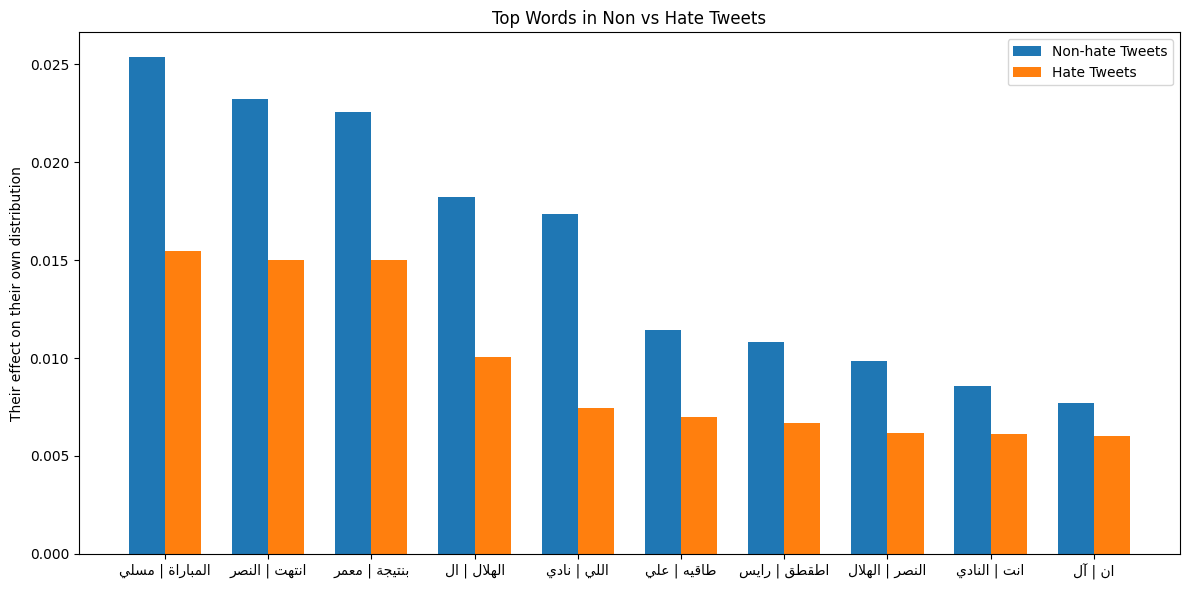

In [23]:

# Assuming not hate_tweets_top_words and hate_tweets_top_words are already defined as in the previous code

# Extract words and counts for good tweets
not_hate_words, not_hate_counts = zip(*not_hate_tweets_top_words)
not_hate_counts = list(not_hate_counts)
not_hate_proportions = [count / not_hate_tweets_word_count for count in not_hate_counts]


# Extract words and counts for bad tweets
hate_words, hate_counts = zip(*hate_tweets_top_words)
hate_counts = list(hate_counts)
hate_proportions = [count / hate_tweets_word_count for count in hate_counts]

# Create the bar chart
plt.figure(figsize=(12, 6))

x = np.arange(10)  # the label locations
width = 0.35  # the width of the bars

rects1 = plt.bar(x - width / 2, not_hate_proportions, width, label='Non-hate Tweets')
rects2 = plt.bar(x + width / 2, hate_proportions, width, label='Hate Tweets')

plt.ylabel('Their effect on their own distribution')
plt.title('Top Words in Non vs Hate Tweets')
plt.xticks(x, [get_display(reshape(not_hate_words[i]))+" | "+get_display(reshape(hate_words[i])) for i in range(0,10)])
plt.legend()

plt.tight_layout()
plt.show()

### 7. Word Cloud Visualization
Generating Word Clouds to visually represent the most prominent words in both hate and non-hate categories.

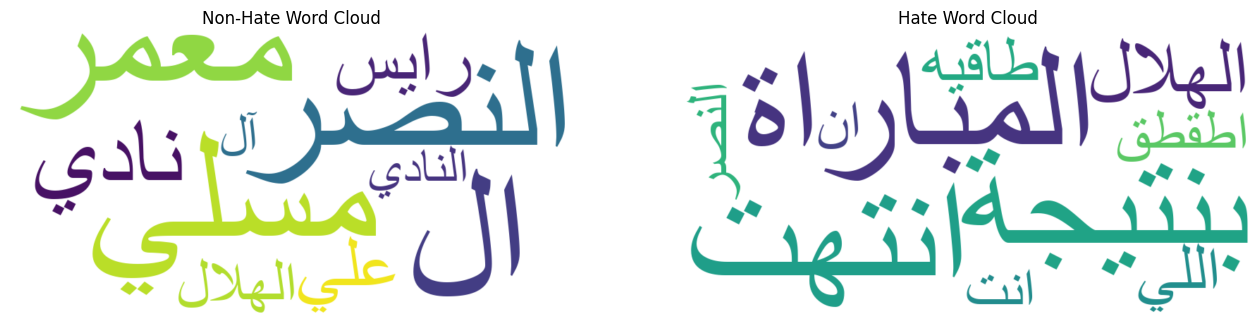

In [24]:
from wordcloud import WordCloud
from arabic_reshaper import reshape
import matplotlib.pyplot as plt

# Combine words into single strings
hate_text = " ".join(hate_words)
not_hate_text = " ".join(not_hate_words)

# Reshape text to ensure correct Arabic connectivity in the image
reshaped_hate_text = (reshape(hate_text))
reshaped_not_hate_text = (reshape(not_hate_text))

# Generate Word Clouds (Requires a font that supports Arabic, e.g., arial.ttf)
# Note: Ensure 'arial.ttf' exists in the environment or change path to a valid Arabic font
wc_hate = WordCloud(font_path="arial.ttf", background_color="white", width=800, height=400).generate(reshaped_hate_text)
wc_not = WordCloud(font_path="arial.ttf", background_color="white", width=800, height=400).generate(reshaped_not_hate_text)

# Plot Word Clouds side-by-side
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.imshow(wc_not, interpolation='bilinear')
plt.axis('off')
plt.title("Non-Hate Word Cloud")

plt.subplot(1, 2, 2)
plt.imshow(wc_hate, interpolation='bilinear')
plt.axis('off')
plt.title("Hate Word Cloud")

plt.show()

### 8. Comparing Corpus Size and Effect
Visualizing the difference in total word counts between the two classes to understand dataset balance.

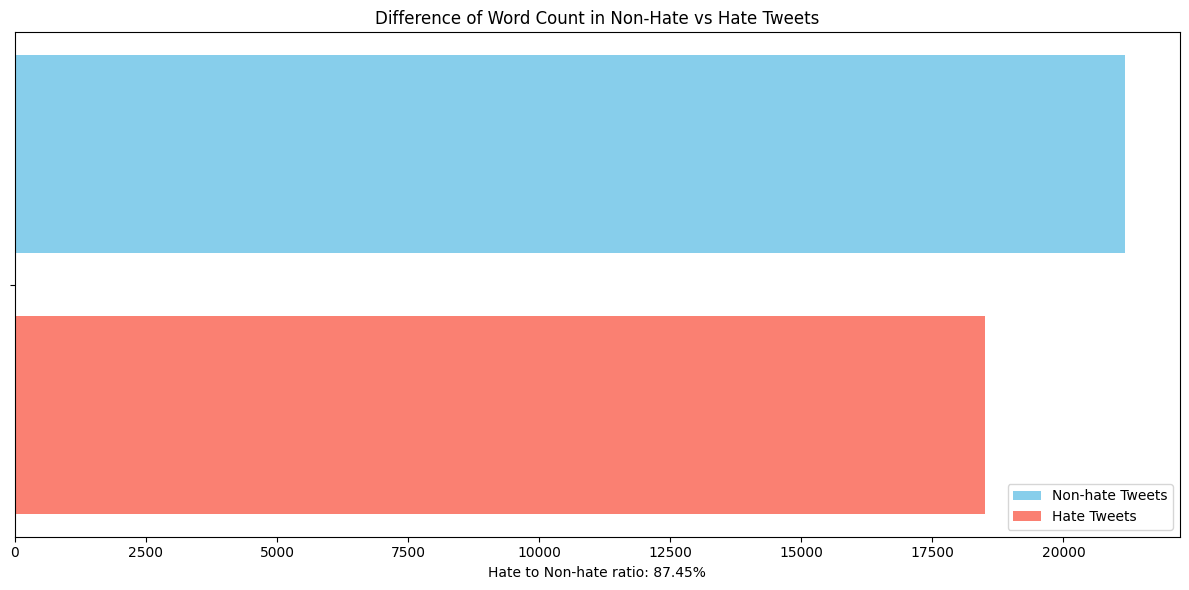

In [25]:
# Create a horizontal bar chart to compare total word counts
fig, ax = plt.subplots(figsize=(12, 6))

# Define positions
x = np.arange(1)
width = 0.5

# Plot bars
rects1 = ax.barh(x + width/2, not_hate_tweets_word_count, width-(0.12), label='Non-hate Tweets', color='skyblue')
rects2 = ax.barh(x - width/2, hate_tweets_word_count, width-(0.12), label='Hate Tweets', color='salmon')

# Calculate ratio
ratio = hate_tweets_word_count / not_hate_tweets_word_count

# Formatting
ax.set_ylabel('')
ax.set_title('Difference of Word Count in Non-Hate vs Hate Tweets')
ax.set_yticks(x)
ax.set_xlabel(f"Hate to Non-hate ratio: {round(ratio*100, 2)}%")
ax.set_yticklabels([''])
ax.legend()

plt.tight_layout()
plt.show()

### 9. Tweet Length Distribution
Analyzing if there is a difference in the length (number of words) of tweets between hate and non-hate speech.

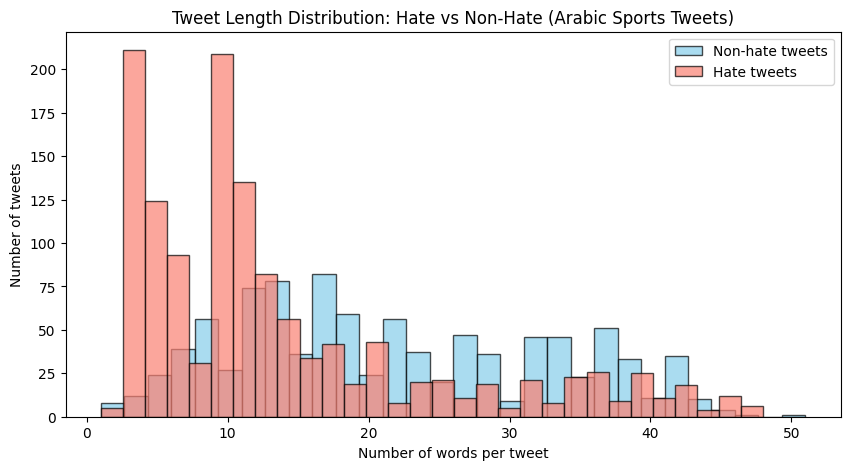

In [26]:
# Plot histograms for tweet length distribution
plt.figure(figsize=(10, 5))
plt.hist(not_hate_tweets['word_count'], bins=30, alpha=0.7, label='Non-hate tweets', color='skyblue', edgecolor='black')
plt.hist(hate_tweets['word_count'], bins=30, alpha=0.7, label='Hate tweets', color='salmon', edgecolor='black')

plt.xlabel('Number of words per tweet')
plt.ylabel('Number of tweets')
plt.title('Tweet Length Distribution: Hate vs Non-Hate (Arabic Sports Tweets)')
plt.legend()
plt.show()